In [1]:
!pip install scanpy gseapy leidenalg igraph

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.5/548.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=71d42d34b7cbefe5880af75d94ca14a006832e2ff5da63913408450d9b7a6a9f
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478

In [2]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Set plotting style
sc.set_figure_params(dpi=100, frameon=False)
sns.set_theme(style="whitegrid")

In [3]:
def load_and_preprocess_data(file_path):
    print("Loading data...")

    # Load CSV file using pandas
    df = pd.read_csv(file_path, index_col=0)  # the first column is gene names

    # Convert to AnnData object
    adata = sc.AnnData(df.T)  # Transpose to make rows = cells, columns = genes

    print("Data loaded. Performing quality control...")

    # Quality control
    sc.pp.filter_cells(adata, min_genes=50)  # Filter cells with fewer than 50 genes
    sc.pp.filter_genes(adata, min_cells=1)   # Filter genes detected in fewer than 1 cell

    print(f"After filtering: {adata.shape}")

    if adata.shape[0] == 0 or adata.shape[1] == 0:
        raise ValueError("Filtered data is empty. Adjust filtering thresholds.")

    # Normalize data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify highly variable genes
    if adata.shape[1] > 0:
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        if adata.var.highly_variable.sum() > 0:
            adata = adata[:, adata.var.highly_variable]
        else:
            print("No highly variable genes found. Skipping selection.")

    if 'total_counts' not in adata.obs.columns:
        adata.obs['total_counts'] = adata.X.sum(axis=1)

    if adata.shape[1] > 0:
        sc.pp.regress_out(adata, ['total_counts'])
    else:
        print("Skipping regression: No genes available.")

    sc.pp.scale(adata, max_value=10)

    return adata

# Load data
adata = load_and_preprocess_data('/content/extracted_file.csv')

Loading data...
Data loaded. Performing quality control...
After filtering: (76, 22262)


<ipython-input-3-072ceed8626c>:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['total_counts'] = adata.X.sum(axis=1)


Performing clustering to identify cell types...


<ipython-input-4-bf2743fc4bda>:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


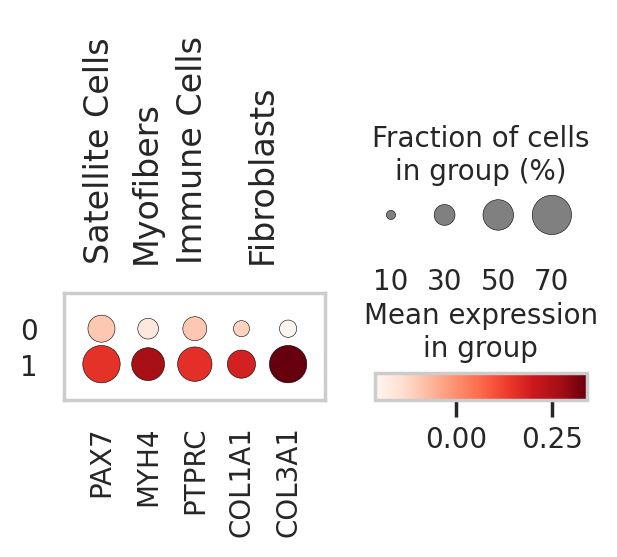

In [4]:
def identify_cell_types(adata):
    print("Performing clustering to identify cell types...")

    if adata.shape[1] == 0:
        raise ValueError(" No genes available after filtering. Adjust filtering criteria.")

    n_pcs = min(40, adata.shape[1])
    if n_pcs == 0:
        raise ValueError(" PCA failed: No genes available. Adjust filtering thresholds.")

    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5)

    marker_genes = {
        'Satellite Cells': ['PAX7'],
        'Myofibers': ['MYH4'],
        'Immune Cells': ['PTPRC'],
        'Fibroblasts': ['COL1A1', 'COL3A1']
    }

    sc.tl.dendrogram(adata, groupby='leiden')
    sc.pl.dotplot(adata, marker_genes, groupby='leiden', dendrogram=True)

    return adata

# Identify cell types
adata = identify_cell_types(adata)

Identifying senescent stem cells...


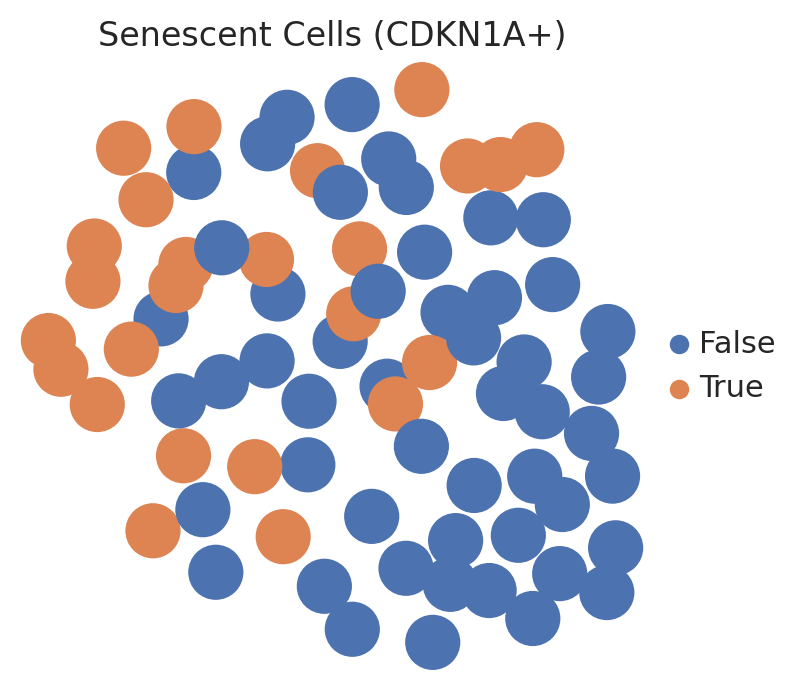

In [5]:
def identify_senescent_cells(adata):
    print("Identifying senescent stem cells...")

    if 'CDKN1A' in adata.var_names:
        adata.obs['senescent'] = adata[:, 'CDKN1A'].X > 0
        sc.pl.umap(adata, color='senescent', title='Senescent Cells (CDKN1A+)')
    else:
        print("Warning: CDKN1A not found in dataset. Skipping senescent cell analysis.")

    return adata

# Identify senescent cells
adata = identify_senescent_cells(adata)

In [6]:
def differential_expression_analysis(adata):
    print("Performing differential gene expression analysis...")

    if 'leiden' not in adata.obs.columns:
        print("Error: Leiden clustering not found. Run clustering first.")
        return pd.DataFrame()

    satellite_cells = adata[adata.obs['leiden'] == '0']

    if 'senescent' not in satellite_cells.obs.columns:
        print("Error: Senescent cell identification missing.")
        return pd.DataFrame()

    senescent = satellite_cells[satellite_cells.obs['senescent']]
    non_senescent = satellite_cells[~satellite_cells.obs['senescent']]

    results = []
    for gene in satellite_cells.var_names:
        stat, pval = mannwhitneyu(senescent[:, gene].X, non_senescent[:, gene].X, alternative="two-sided")
        results.append({'gene': gene, 'stat': stat, 'pval': pval})

    results_df = pd.DataFrame(results)

    _, results_df['adj_pval'], _, _ = multipletests(results_df['pval'], method='fdr_bh')

    results_df = results_df.sort_values('adj_pval')

    results_df.to_csv('differential_expression_results.csv', index=False)

    return results_df

# Run differential expression analysis
results_df = differential_expression_analysis(adata)

Performing differential gene expression analysis...


Visualizing results...


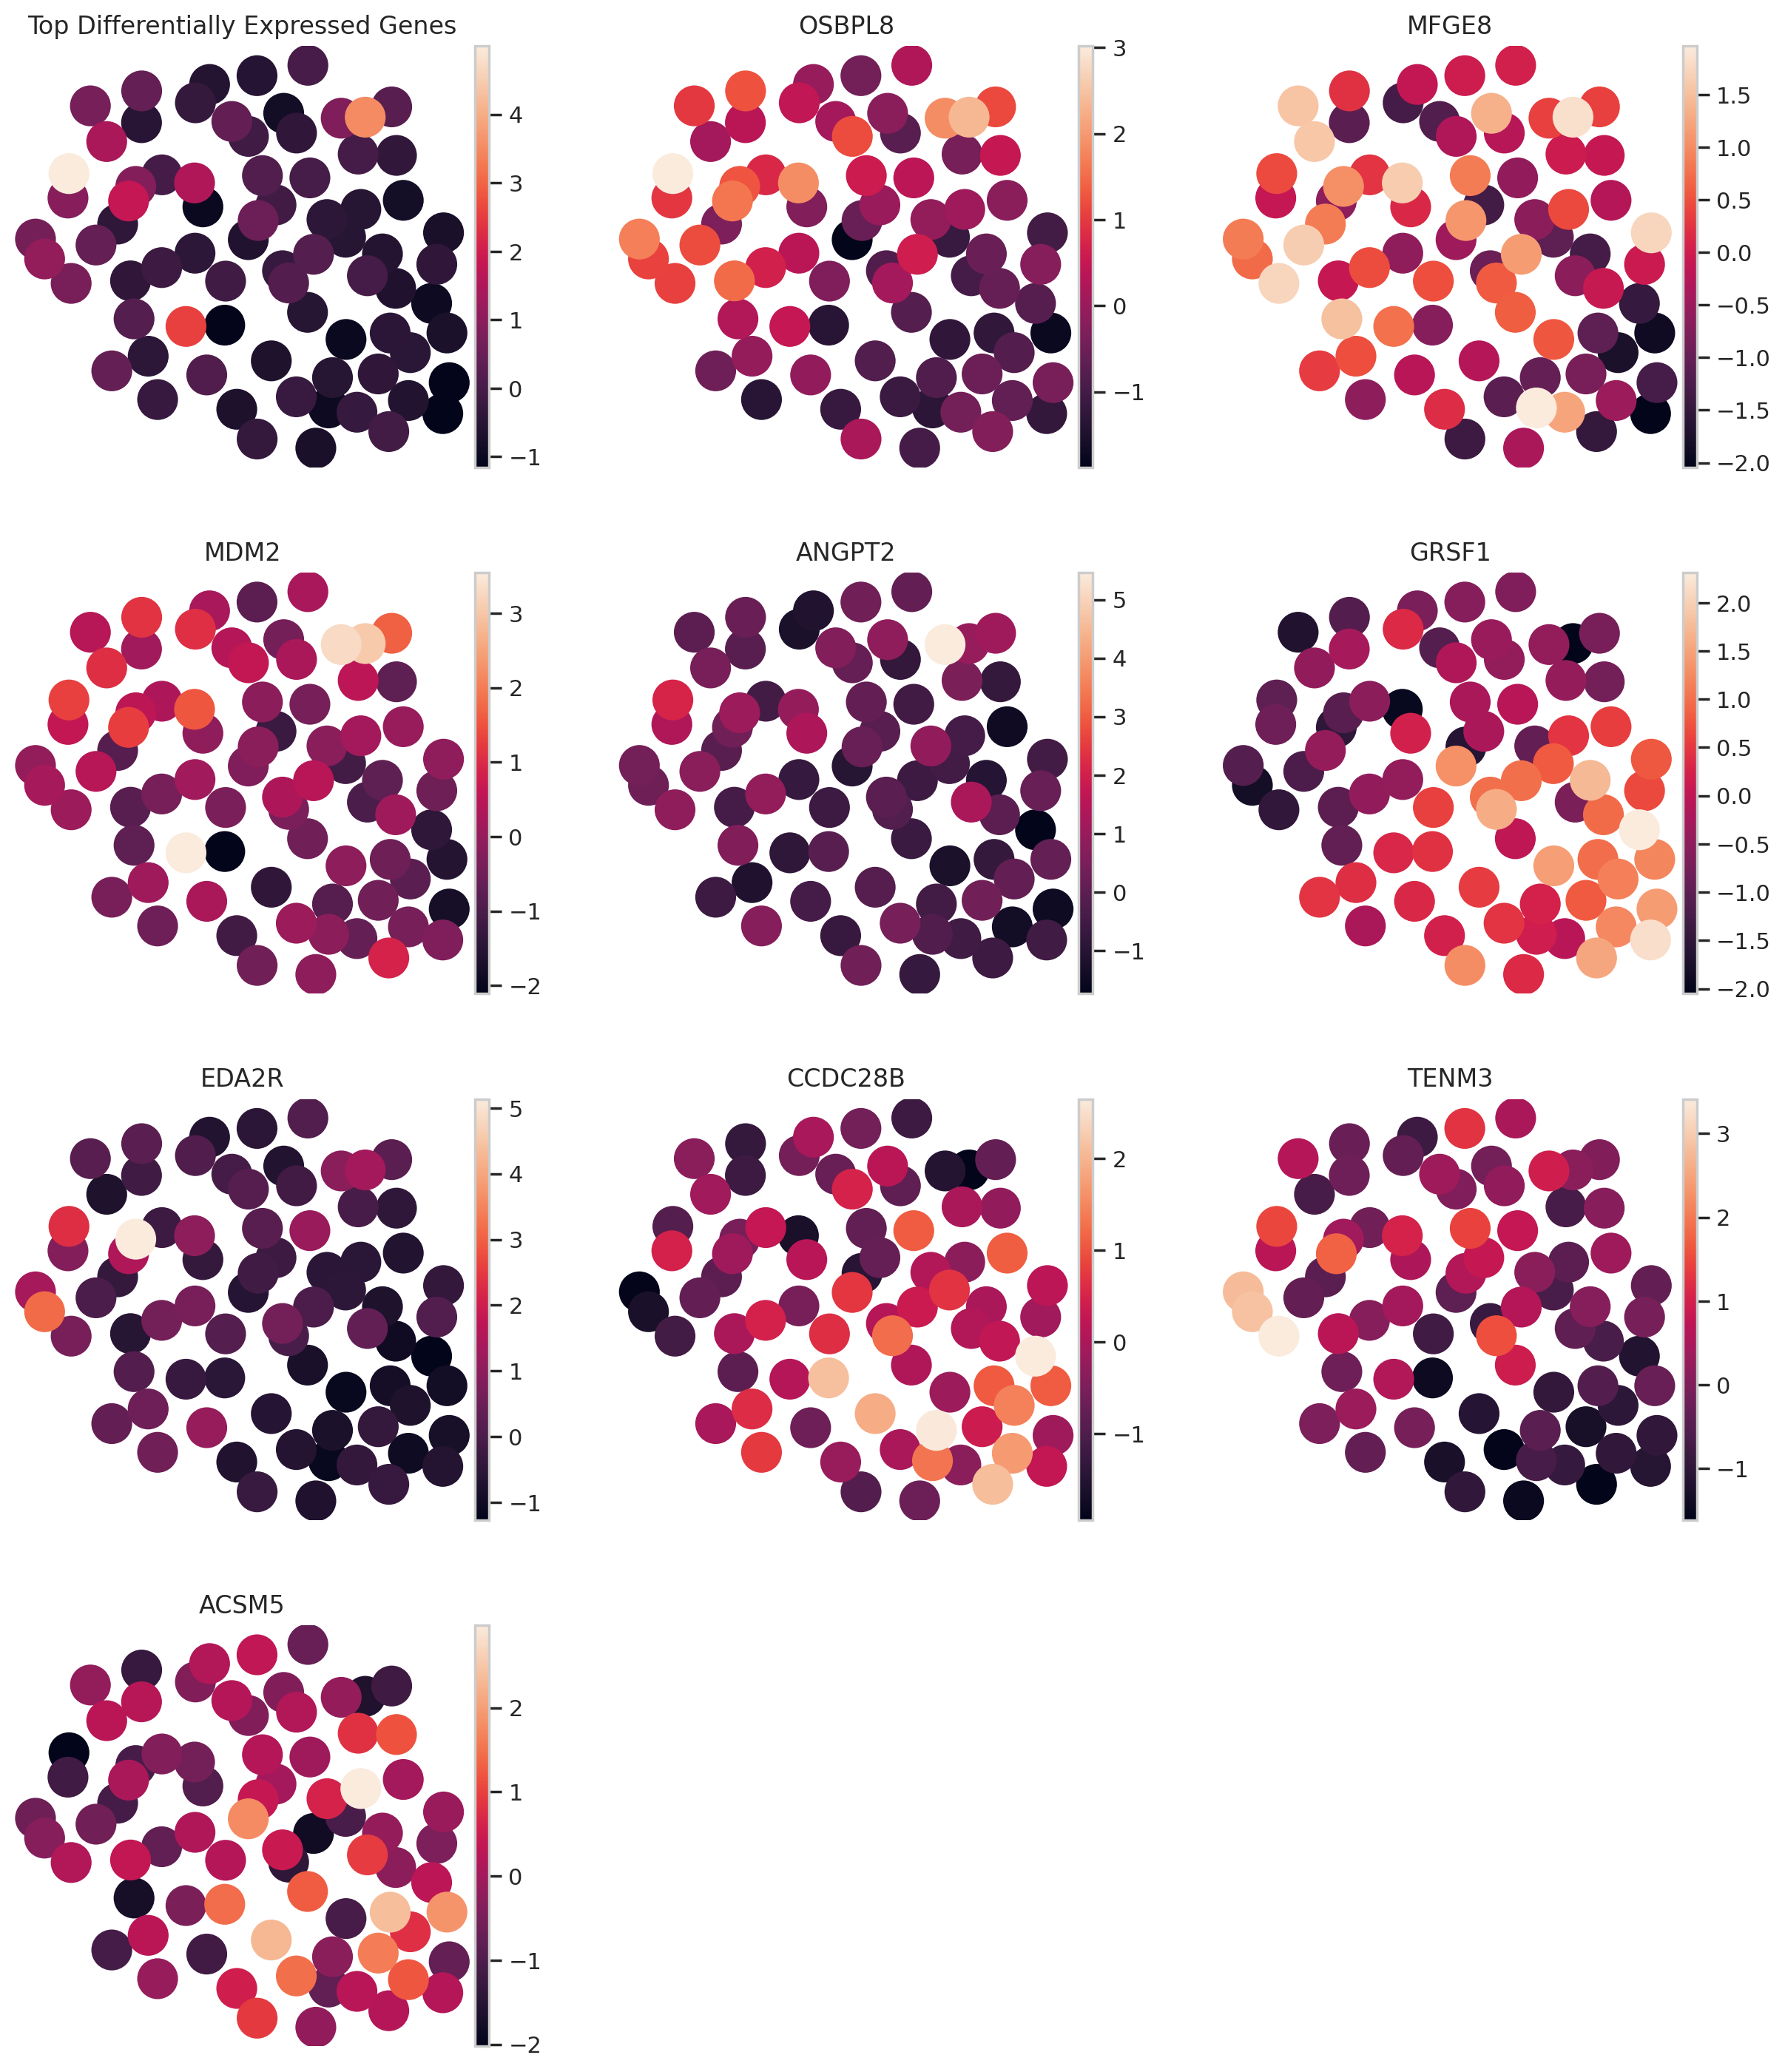

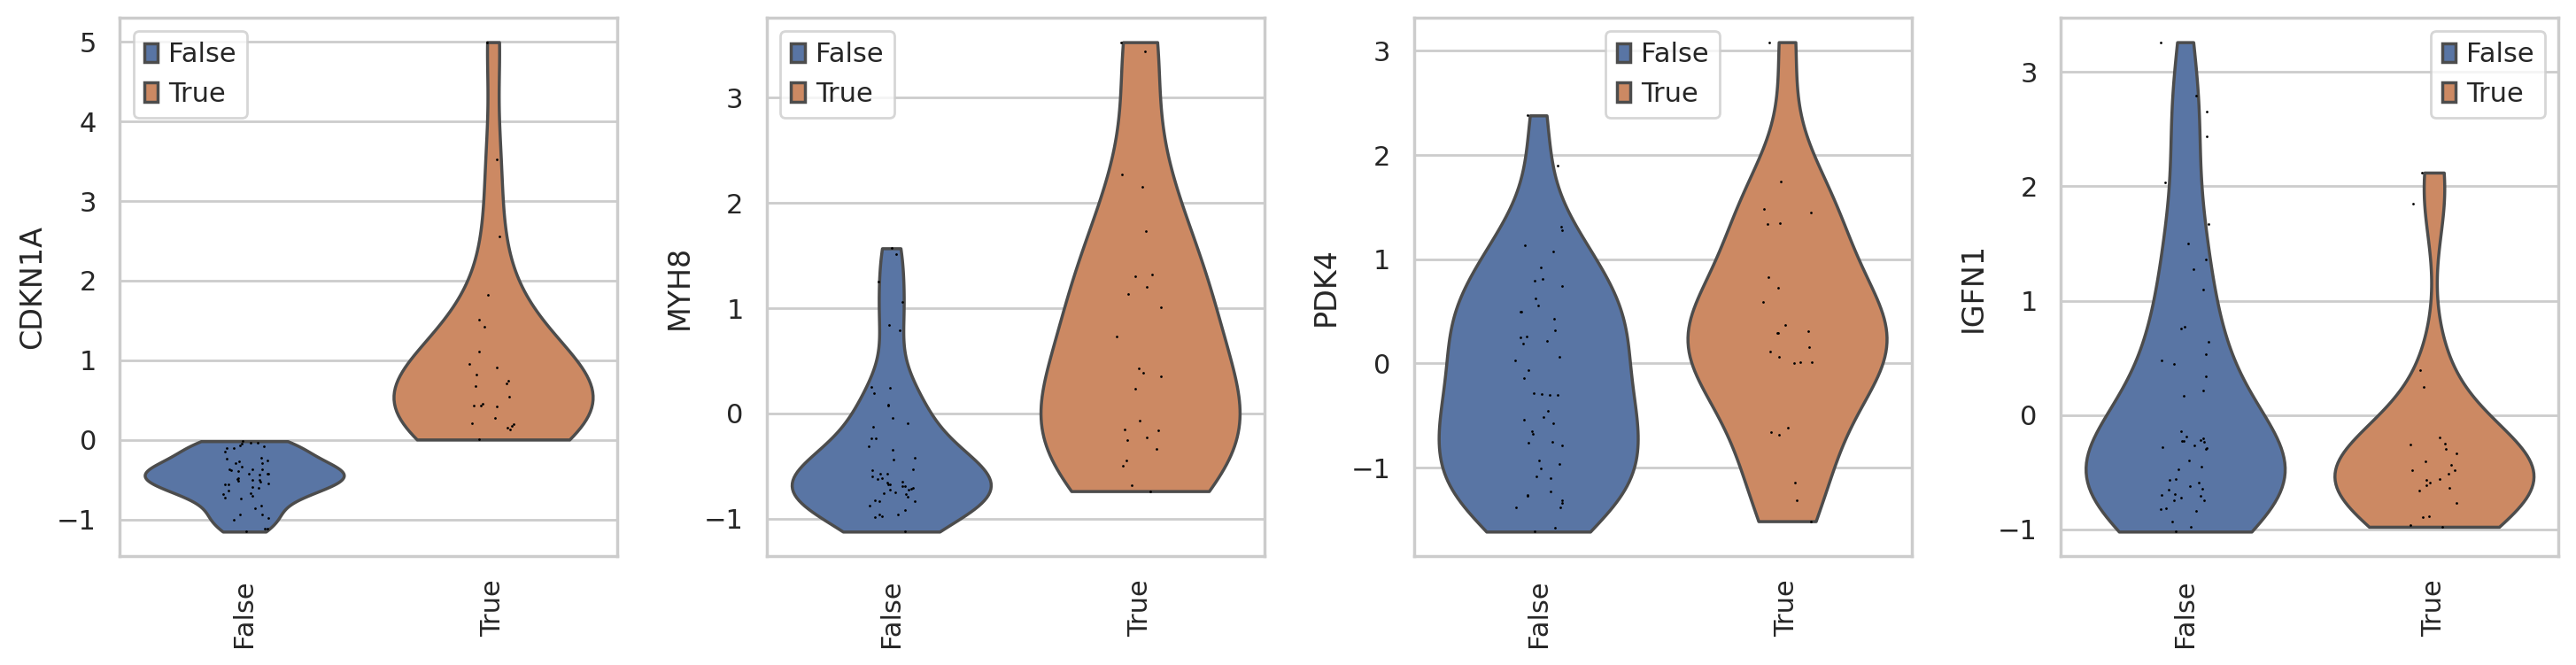

In [7]:
def visualize_results(adata, results_df):
    print("Visualizing results...")

    top_genes = results_df.head(10)['gene'].tolist()
    sc.pl.umap(adata, color=top_genes, ncols=3, title='Top Differentially Expressed Genes')

    adata.obs['senescent'] = adata.obs['senescent'].astype('category')

    sc.pl.violin(adata, keys=['CDKN1A', 'MYH8', 'PDK4', 'IGFN1'], groupby='senescent', rotation=90)

# Visualize results
visualize_results(adata, results_df)